# Run Correlation-Based Analyses

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

Use this to assess if a correlation between a dependent variable and an independent variable is statistically significant using permutation analysis. 

Further, follow this up with a contrast analysis which sees which categorical variables have significantly different correlations from each other. 

Notes:
- To best use this notebook, you should be familar with mixed effects models

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [ ]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/resources/datasets/05c_Howard_MetaAlzheimerReview_DBS-TMS_Coordinates/metadata/comparison_data.xlsx'
sheet = 'Sheet1' #'master_list'

In [ ]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/tms_meta_analysis/redo'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
data_df


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
data_df.columns

In [ ]:
drop_list = ['CNM_Damage_Roi_old', 'cohens_D_redo']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
data_df

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

In [ ]:
# data_df.loc[data_df['Exclusion_Reason']=='iTBS', 'Included'] = 1
# data_df

Set the parameters for dropping rows

In [ ]:
data_df.columns

In [ ]:
column = 'Included'  # The column you'd like to evaluate
condition = 'equal'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 0 # The value to compare against

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

Regress out a Covariate

In [ ]:
for col in data_df.columns:
    print(col)

In [ ]:
dependent_variable_list = ['cohens_D_redo']
regressors = ['Stimulation_site', 'Frequency']

In [ ]:
for col in regressors:
    if data_df[col].dtype == 'O':  # object/categorical
        data_df[col] = data_df[col].fillna(data_df[col].mode()[0])
    else:  # numeric
        data_df[col] = data_df[col].fillna(data_df[col].mean())
data_df[regressors].isna().sum()

In [ ]:
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=regressors)
print(adjusted_dep_vars_list)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
data_df.columns

In [ ]:
# Remove anything you don't want to standardize
# cols_not_to_standardize = ['Overall_Cognition_Cohen_s_D']

In [ ]:
# data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

Misc Filtering

In [ ]:
# data_df = data_df[data_df['Pre_Post_Memory_Effect_Size__Cohen_s_D_'].abs() <= 10]

# 02 - Perform Basic Correlation

In [88]:
data_df.columns

Index(['Study', 'Included', 'DOI', 'RCT_Design', 'Age_range', 'CDR',
       'Active_N', 'Sham_N', 'Mean_Age', 'Active_Age', 'Sham_Age',
       'Active_M_F', 'Sham_M_F', 'Active_Education__Yrs_',
       'Sham_Education__Yrs_', 'Active_AD_Treatment_Proportion', 'Diagnosis',
       'Diagnostic_Criteria', 'Stim_Type', 'Frequency', 'good_study',
       'Intensity', 'Navigation', 'Total_Pulses_session', 'session',
       'Total_pulses', 'Overall_Cognition_Test', 'Overall_Cognition_Cohen_s_D',
       'Redo_test', 'cohens_D_redo', 'Verbal_Memory_Test', 'Memory_Cohen_s_D',
       'Stimulation_site', 'Stim_Coordinate', 'Exclusion_Reason', 'roi_path',
       'roi_path_old', 'subject', 'CNM_Damage_Roi_old', 'CNM_Damage_Roi_new',
       'cohens_D_redo_residual'],
      dtype='object')

In [89]:
x_col = 'CNM_Damage_Roi_old'
y_col = 'cohens_D_redo_residual'

<Figure size 432x432 with 0 Axes>

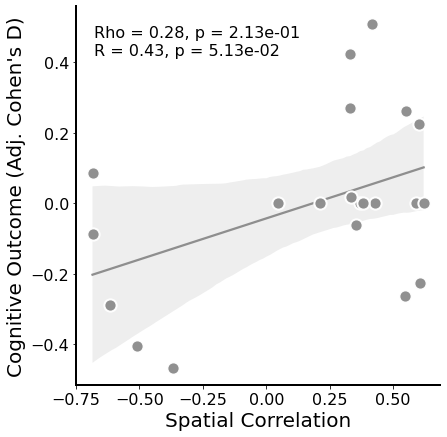

In [91]:
from calvin_utils.statistical_utils.scatterplot import simple_scatter
simple_scatter(data_df, x_col, y_col, '', 
               x_label="Spatial Correlation",
               y_label="Cognitive Outcome (Adj. Cohen's D)",
               out_dir='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/tms_meta_analysis/redo_for_simon', flip_axes=False)

In [ ]:
out_dir

In [ ]:
data_df.columns

In [ ]:
import itertools
from scipy.stats import pearsonr, spearmanr
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates

scores = ['score', 0, 0]
dependent_variable_list = ['cohens_D_redo']
covariate_options = ['DOI', 'RCT_Design', 'Age_range', 'CDR', 'Active_N', 'Sham_N',
       'Mean_Age', 'Active_Age', 'Sham_Age', 'Active_M_F', 'Sham_M_F',
       'Active_Education__Yrs_', 'Sham_Education__Yrs_',
       'Active_AD_Treatment_Proportion', 'Diagnosis', 'Diagnostic_Criteria',
       'Stim_Type', 'Frequency', 'Intensity', 'Navigation',
       'Total_Pulses_session', 'session', 'Total_pulses',
       'Overall_Cognition_Test', 'Redo_test', 'Verbal_Memory_Test', 'Memory_Cohen_s_D',
       'Stimulation_site', 'Stim_Coordinate', 'Included', 'Exclusion_Reason', 'subject']
for combination in itertools.combinations(covariate_options, 3):
    covariates = list(combination)
    data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=covariates)
    res_col = adjusted_dep_vars_list[0]
    r, p = spearmanr(data_df.loc[:, res_col], data_df.loc[:, 'CNM_Damage_Roi_old'], alternative='two-sided')
    if r > scores[1]:
        scores[0] = combination
        scores[1] = r
        scores[2] = p

In [ ]:
print(scores)

# Correlate Variable with All Other Variables

In [ ]:
x_col = 'flipped_lesions_all_datasets_weighted_avg_r_map_cosine'

In [ ]:
from calvin_utils.statistical_utils.correlation_barplot import CorrelationBarPlot
plotter = CorrelationBarPlot(data_df, x_col=x_col, method="spearman")
corr_series = plotter.run(save_path=None)

Focus on correlations above a threhsold

In [ ]:
strong_corrs = plotter.plot_threshold(0.3)      # |r| ≥ 0.4 plot